<a href="https://www.kaggle.com/code/ocanaydin/dcgan-fashion-mnist?scriptVersionId=114842636" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

**Inspried from : [https://www.tensorflow.org/tutorials/generative/dcgan](http://)**

**LIBRARIES**

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt

**LOAD DATA AND PREPARE IT**

In [ ]:
(train_images,train_labels),(_,_) = tf.keras.datasets.fashion_mnist.load_data()

In [4]:
#Normalize images -1 to 1.
train_images = train_images.reshape(train_images.shape[0],28,28,1).astype("float32")
train_images = (train_images - 127.5) / 127.5

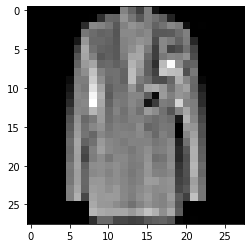

4


In [5]:
#Show random idx image from dataset.
import random
idx = random.randint(0,len(train_images))
plt.imshow(train_images[idx] * 127.5 + 127.5,cmap = "gray")
plt.show()
print(train_labels[idx])

In [ ]:
#Create dataset from images.
BUFFER_SIZE = 60000
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

**GENERATOR**

In [7]:
#Use upsampling to create generator model.You can change the structure of network to obtain more robust generator.
from tensorflow.keras import layers
def generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size
    
    #(1)Upsampling
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    #(2)Upsampling
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    #(3)Upsampling
    model.add(layers.Conv2DTranspose(16, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 28, 28, 16)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    #3(Upsampling)
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

2022-12-27 10:56:06.670079: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


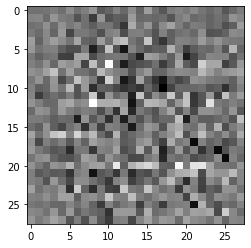

In [8]:
#Create an image from noise using (untrained) generator.
generator = generator_model()
noise = tf.random.normal((1,100))
gen_img = generator(noise,training = False)

plt.imshow(gen_img[0,:,:,0] * 127.5 + 127.5,cmap = "gray")
plt.show()

**DISCRIMINATOR**

In [9]:
#CNN based discriminator classifier.
#You can change the structure of network to beat generator.
def discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [10]:
#Use (untrained) classifier to make decision(positive => real,negative => fake.)
discriminator = discriminator_model()
decision = discriminator(gen_img)
print(decision)

tf.Tensor([[-0.00039428]], shape=(1, 1), dtype=float32)


In [11]:
#Loss function.
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

In [12]:
#Discriminator LOSS
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [13]:
#Generator LOSS
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [14]:
#They will be trained seperately.
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

**SAVE CHECKPOINTS**

In [15]:
import os
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

**DEFINE TRAINING**

In [16]:
#Training parameters.
EPOCHS = 80
noise_dim = 100
num_ex_to_gen = 16

In [17]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    #Create an noise
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        #Generated image using above noise.
        generated_images = generator(noise, training=True)
        #Use discriminator to decide the real or fake.
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        #Calculate losses.
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    #Get the gradients of both generator and discriminator with respect to their losses.
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    #Update gradients to train both generator and discriminator accurately.
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [18]:

import time
from IPython import display
#This seed will be using as a test image in below.
seed = tf.random.normal((num_ex_to_gen,noise_dim))

def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        #Train
        for image_batch in dataset:
            train_step(image_batch)

        # Produce images for the GIF as you go
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                             epoch + 1,
                             seed)

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                           epochs,
                           seed)

**GENERATE AND SAVE IMAGES**

In [19]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)
    
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5,cmap = "gray")
        plt.axis('off')
    
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

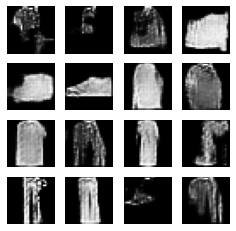

In [20]:
train(train_dataset,EPOCHS)

**CREATE A GIF**

In [21]:
import PIL
def display_image(epoch_number):
    return PIL.Image.open("image_at_epoch_{:04d}.png".format(epoch_number))

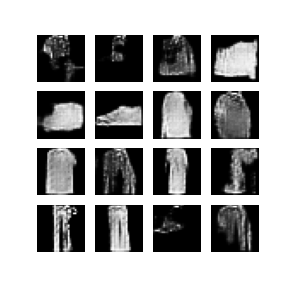

In [22]:
display_image(80)

**CREATE IMAGES BY TRAINED GENERATOR**

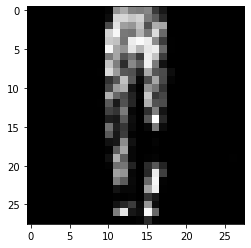

In [23]:
idx = random.randint(0,16)
gen_img = tf.random.normal((16,100))
preds = generator(gen_img,training = False)

plt.imshow(preds[idx,:,:,0] * 127.5 + 127.5,cmap = "gray")
plt.show()

In [24]:
def decode_decs(decision):
    decs = []
    for i in range(len(decision)):
        if decision.numpy()[i] >= 0:
            decs.append("Real")
        else:
            decs.append("Fake")
    return decs

In [25]:
#Decision from discriminator.
decision = discriminator(preds)
decs = decode_decs(decision)
print(decs)

['Fake', 'Fake', 'Fake', 'Fake', 'Fake', 'Real', 'Fake', 'Fake', 'Fake', 'Fake', 'Fake', 'Fake', 'Real', 'Fake', 'Fake', 'Fake']


In [26]:
#Find tricked images indexes.
idxs = []
for i in range(len(decs)):
    if decs[i] == "Real":
        idxs.append(i)
print(idxs)

[5, 12]


In [28]:
print(decision)

tf.Tensor(
[[-1.4940108 ]
 [-0.02484684]
 [-0.26631266]
 [-1.1790115 ]
 [-1.3271731 ]
 [ 0.5131079 ]
 [-0.6938545 ]
 [-2.1396306 ]
 [-1.09547   ]
 [-1.0808555 ]
 [-0.14559531]
 [-0.10392965]
 [ 0.20003973]
 [-0.6344491 ]
 [-0.23215097]
 [-2.034937  ]], shape=(16, 1), dtype=float32)


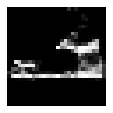

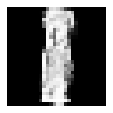

In [29]:
#Show generator beaten discriminator images.
fig2 = plt.figure(figsize = (4,4))
for i in range(len(idxs)):
    plt.subplot(2,2,i+1)
    plt.imshow(preds[idxs[i],:,:,0] * 127.5 + 127.5,cmap = "gray")
    plt.axis("off")
    plt.show()